In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import *
sys.path.append('..')
from audio import *

In [3]:
#To have reproducible results with fastai you must also set num_workers=1 in your databunch, and seed=seed
#in split_by_rand_pct
seed = 42
# python RNG
random.seed(seed)
# pytorch RNGs
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
# numpy RNG
np.random.seed(seed)

## Introduction

In this notebook we will be using the library to compete in the [Google Brain Tensorflow Speech Challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/), a kaggle competition that ended ~1 year ago. The goal of the competition is to recognize one-word commands, like stop, go, up, down...etc It was highly competitive so, in order to finish high, we will need to use more advanced techniques, which is a great opportunity to show how to use a variety of FastAI Audio features. Our approach will be as follows

- Pre-step: Algorithmically generating different types of noise for the "silence (no word)" class
- Base model 1: Mel Frequency Cepstral Coefficient (MFCC) along with delta and accelerate (1st and 2nd derivatives of MFCC) appended in the 2nd and 3rd channels
- Base model 2: Melspectrogram from scratch (no pretraining)
- Use base models to predict on the test set, and pseudolabel (semi-supervised learning) the test set where at least one model is extremely confident (> 99.9%).
- Fine tune both models on the original training data + pseudolabeled data.
- Pseudolabel again, using a lower threshold (at least one model 97.5% confident), and fine tune both models some more.
- Ensemble (use both models to make our final predictions)

Note that the first step here should always be EDA (exploratory data analysis) and getting to know the test/train set and how they differ. This is a tutorial designed to demonstrate audio techniques, so we are skipping EDA, but I will try to mention data discrepencies I found as they related to specific design choices.

There is still a lot of room to make changes and get even better results. Many of my design choices were arbitrary and didn't involve a huge amount of experimentation with the possible options, so do not in any way consider this authoritative. If you have an idea for a different route, test it and then tell us about it in the audio thread if it works (and especially if it doesn't, we all should be sharing negative results as well). 

## Grabbing the dataset

##### Note: this is a large dataset, containing ~65000 files for training and ~158000 for testing. 3.76GB in total

The following is directly from the 2019 Part 1, lesson 3 Planet Notebook from fastai, adjusted for our purposes.

The googlespeech dataset isn't available on the [fastai dataset page](https://course.fast.ai/datasets) but you can download it from Kaggle. Let's see how to do this by using the [Kaggle API](https://github.com/Kaggle/kaggle-api) as it's going to be pretty useful to you if you want to join a competition or use other Kaggle datasets later on.

First, install the Kaggle API by uncommenting the following line and executing it, or by executing it in your terminal (depending on your platform you may need to modify this slightly to either add `source activate fastai` or similar, or prefix `pip` with a path. Have a look at how `conda install` is called for your platform in the appropriate *Returning to work* section of https://course.fast.ai/. (Depending on your environment, you may also need to append "--user" to the command.)

In [4]:
#! pip install kaggle --upgrade

Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal). For Windows, uncomment the last two commands.

In [5]:
#! mkdir -p ~/.kaggle/
#! mv kaggle.json ~/.kaggle/

# For Windows, uncomment these two commands
# ! mkdir %userprofile%\.kaggle
# ! move kaggle.json %userprofile%\.kaggle

You're all set to download the data from [TensorFlow  Speech Recognition Challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/). You **first need to go to its main page and accept its rules**, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a `403 forbidden` error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on *Rules* tab, and then scroll to the bottom to find the *accept* button).

In [6]:
path = Path('../data/google_speech')
# path.mkdir(parents=True, exist_ok=True)
# ! kaggle competitions download -c tensorflow-speech-recognition-challenge -p {path}

To extract the content of this file, we'll need 7zip, so uncomment the following line if you need to install it (or run `sudo apt install p7zip-full` in your terminal).

In [7]:
#! conda install -y -c haasad eidl7zip

And now we can unpack the data (uncomment to run - this will take quite a long time to run for the testset).

In [8]:
# ! 7za -o{path} x {path}/train.7z 
# ! 7za -o{path} x {path}/test.7z 

## Organizing the data

In [9]:
PATH_BASE = Path('../data/google_speech/')
PATH_TEST = PATH_BASE/'test/audio/'
PATH_DATA = PATH_BASE/'train/audio/'

The data supplied isn't actually what we need to begin training. Below we will see all the data we just downloaded, 20 or so words, but the 12 classes are 'up', 'down', 'yes', 'no', 'left', 'right', 'stop', 'go', 'on', 'off', 'silence', and 'unknown'. This means we need to copy all the words that don't have their own class into 'unknown'. Normally I would do this in a separate folder in case I needed to come back and grab the originals, but for memory's sake we will do it here in one go. 

### Handling the provided silence examples

"Silence" examples are included in the \_background_noise_ folder. We want to segment them into 1s chunks and add them to the silence folder, but first let's take a look at what's there. 

In [62]:
(PATH_DATA/'_background_noise_').ls()

[PosixPath('../data/google_speech/train/audio/_background_noise_/doing_the_dishes.wav'),
 PosixPath('../data/google_speech/train/audio/_background_noise_/running_tap.wav'),
 PosixPath('../data/google_speech/train/audio/_background_noise_/README.md'),
 PosixPath('../data/google_speech/train/audio/_background_noise_/exercise_bike.wav'),
 PosixPath('../data/google_speech/train/audio/_background_noise_/dude_miaowing.wav'),
 PosixPath('../data/google_speech/train/audio/_background_noise_/pink_noise.wav'),
 PosixPath('../data/google_speech/train/audio/_background_noise_/white_noise.wav')]

Next let's look at how many seconds long each of these files are. Note torchaudio always has a leading channel of size 1 for mono audio, so you can either squeeze it and take the len, or take the 2nd dimension of the shape to check how many samples are in the file. We divide that by sample rate to get the length in time of the clip.

In [63]:
count = 0
for p in (PATH_DATA/'_background_noise_').ls():
    if p.suffix != '.wav': continue 
    y, sr = torchaudio.load(p)
    seconds = len(y.squeeze(0))/sr
    print(p.stem, seconds)
    count += seconds
print("\nTotal Time", count)

doing_the_dishes 95.183125
running_tap 61.1555
exercise_bike 61.253875
dude_miaowing 61.8056875
pink_noise 60.0
white_noise 60.0

Total Time 399.3981875


That means 399 clips if we grab non-overlapping chunks. But we can iterate over them with a hop of 4000 samples (0.25s) and get more clips. Is this a good idea? Who knows, but it will get us to around 1600 clips. If we take the reverse as well we will have about 3200. 

The code below will window over the chunks with a 1s/16000sample window with a hop of 0.25s/4000sample and save those 1s chunks and their reverse as silence samples. 

In [66]:
#Here we use the alternate way to check the length of the signal, by looking at shape[1]
os.makedirs(PATH_DATA/'silence', exist_ok=True)
for p in (PATH_DATA/'_background_noise_').ls():
    if p.suffix != '.wav': continue 
    y, sr = torchaudio.load(p)
    for start in range(0, y.shape[1]-16000, 4000):
        normal_savepath = str(PATH_DATA/f'silence/{p.stem}-{start}.wav')
        reverse_savepath = str(PATH_DATA/f'silence/{p.stem}-{start}-reverse.wav')
        torchaudio.save(normal_savepath, y[:,start:start+16000], sr)
        torchaudio.save(reverse_savepath, y[:,start:start+16000], sr)

In [67]:
len((PATH_DATA/'silence').ls())

3152

Success! Here are some examples of the silence clips we'll be feeding to our model

In [68]:
for _ in range(5): display(Audio(str(random.choice((PATH_DATA/'silence').ls()))))

### Processing the normal commands

The commands that we are to use for the "unknown" class come from a bunch of different folders. We need to move them to one "unknown" folder before loading them. We also need to take care because some of the files in the 'unknown' subfolders can have the same filename. To avoid overwriting files with the same name, we will include the word being said in the new filename. 

In [76]:
commands = set('up down yes no left right stop go on off silence unknown'.split())
unknown = set('zero one two three four five six seven eight nine tree bed wow happy bird house cat marvin sheila dog'.split())
folders = set([str(x).split('/')[-1] for x in PATH_DATA.ls()])
#last command is just to check we didn't miss any of the unknown classes
folders - (commands | unknown)

{'_background_noise_'}

In [77]:
PATH_UNK = PATH_DATA/"unknown" 
os.makedirs(PATH_UNK, exist_ok=True)
for folder in unknown: 
    for f in (PATH_DATA/folder).ls():
        origin = f.parent.stem
        new_filename = f"{origin}-{f.name}"
        shutil.move(str(f), str(PATH_UNK/new_filename))

In [78]:
len(PATH_UNK.ls())

41039

## Configuring our model and deciding on settings

Since we are using human speech we will try our MFCC (mel frequency cepstral coefficients) an audio feature extraction that is designed to identify unique components of human speech. To do this in the library we just need to set `mfcc=True` in our `AudioConfig`. We can also run a quick test on partial data and see if appending the delta/accelerate derivatives in the second/third channel will do us any good. To do this just set `delta=True`. 

In [15]:
sg_cfg= SpectrogramConfig(hop=72, f_max=8000, top_db=80, f_min=20)
cfg = AudioConfig(cache=True, max_to_pad=None, mfcc=True, delta=True, sg_cfg=sg_cfg)

Before deciding if we need other preprocessing, let's load up an AudioList and take a quick look at the stats.

In [20]:
al_train = AudioList.from_folder(PATH_DATA, config=cfg).filter_by_folder(exclude='_background_noise_')

Sample Rates: 
16000: 67873 files


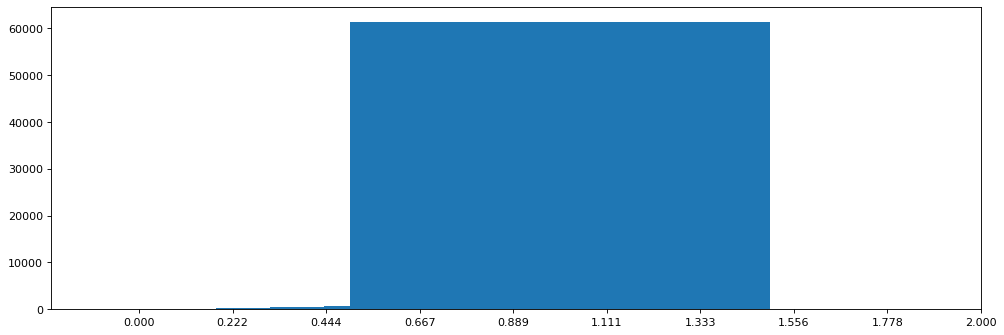

In [94]:
lens = al_train.stats(prec=1)

In [16]:
list(lens.values())[0:25]

NameError: name 'lens' is not defined

All our files are the same sample rate, so we don't need resampling, but we do need to set them to a fixed length since we do have a few outliers. Since they are all already close to the right length, we can do a one-off pad to 1 sec using max_to_pad.

In [21]:
cfg.max_to_pad = None
cfg.duration = 1000

In [40]:
data_pct = 0.10
db_audio = (al_train.use_partial_data(data_pct)
         .split_by_rand_pct(0.2, seed=seed)
         .label_from_folder()
         .transform(None)
         .databunch(bs=256))

In [41]:
db_audio.show_batch()

------------------------------------------------------------
File: ../data/google_speech/train/audio/no/dec73123_nohash_0.wav
Total Length: 0.77 seconds
Label: no


Shape: 20x222


Shape: 20x222


Shape: 20x222
------------------------------------------------------------
File: ../data/google_speech/train/audio/unknown/sheila-fbe51750_nohash_3.wav
Total Length: 0.94 seconds
Label: unknown


Shape: 20x222


Shape: 20x222


Shape: 20x222
------------------------------------------------------------
File: ../data/google_speech/train/audio/unknown/two-e8e960fd_nohash_0.wav
Total Length: 1.0 seconds
Label: unknown
0.0s-1.0s of original clip


Shape: 20x222


Shape: 20x222


Shape: 20x222


In [42]:
learn = audio_learner(db_audio, pretrained=False)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


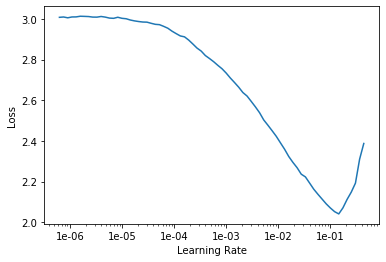

In [43]:
learn.lr_find();learn.recorder.plot()

In [44]:
learn.fit_one_cycle(15, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.204001,8.906509,0.111275,00:05
1,1.624228,1.983003,0.625645,00:05
2,1.227900,1.163708,0.691968,00:05
3,0.957162,0.687112,0.787030,00:05
4,0.790805,0.664755,0.795873,00:05
5,0.659631,0.678253,0.797347,00:05
6,0.546765,0.966910,0.751658,00:05
7,0.456196,0.460146,0.865144,00:05
8,0.384585,0.512002,0.846721,00:05
9,0.311498,0.319844,0.895357,00:05


With no pretraining, no fine-tuning, and these tiny images, we are still able to recognize human speech with 92% accuracy using only 1/10 of our data. This is pretty incredible. Let's try it again with the delta turned off and see if it is actually having a positive effect.

In [45]:
cfg.delta=False

In [48]:
#just one channel now, no delta/accelerate
db_audio = (al_train.use_partial_data(data_pct)
         .split_by_rand_pct(0.2, seed=seed)
         .label_from_folder()
         .transform(None)
         .databunch(bs=256))
db_audio.show_batch(1)

------------------------------------------------------------
File: ../data/google_speech/train/audio/no/dec73123_nohash_0.wav
Total Length: 0.77 seconds
Label: no


Shape: 20x222


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


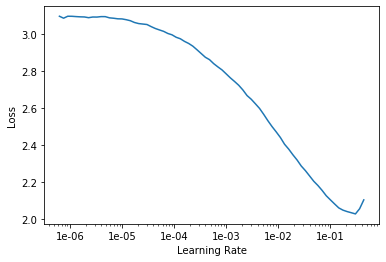

In [49]:
learn = audio_learner(db_audio, pretrained=False)
learn.lr_find(); learn.recorder.plot()

It's a bit of a different curve, and I have, in all honesty, no idea what this means. So let's train on same schedule and compare results

In [50]:
learn.fit_one_cycle(15, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.241738,7.736968,0.123803,00:07
1,1.641334,2.172756,0.658069,00:05
2,1.237900,2.240009,0.526898,00:05
3,0.986473,1.040603,0.714812,00:05
4,0.831639,0.944459,0.758290,00:05
5,0.680433,0.587824,0.818718,00:05
6,0.574300,0.421284,0.859985,00:04
7,0.475291,0.390549,0.877671,00:05
8,0.394423,0.412481,0.881356,00:05
9,0.322531,0.383178,0.872513,00:05


Seems to be a little better with delta/accelerate, let's keep it around.

In [55]:
#Here's a nifty command to check how much memory our GPU is consuming. 
!nvidia-smi

Sat Jul 13 19:04:24 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.72       Driver Version: 410.72       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                  N/A |
| N/A   51C    P0    23W /  75W |   1617MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

It looks like we have lots of room if we want to try something like a lower hop or upsampling
Honestly, upsampling size seems dumb, but I've seen it work on other things, so let's try as our last pre-test
At the very least it'll give us a clearer view of what an MFCC looks like. Credit for the idea of upsampling a spectrogram with bilinear interpolation goes to [Miguel Pinto](https://forums.fast.ai/u/mnpinto/summary) who used it in his awesome 6th place finish in the Freesound 2019 competition.

------------------------------------------------------------
File: ../data/google_speech/train/audio/no/dec73123_nohash_0.wav
Total Length: 0.77 seconds
Label: no


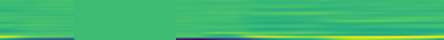

Shape: 40x444


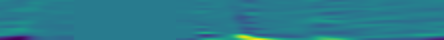

Shape: 40x444


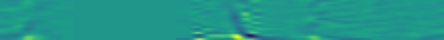

Shape: 40x444


In [56]:
#just one channel now, no delta/accelerate
cfg.delta = True
tfms = get_spectro_transforms(mask_frequency=False, mask_time=False, size=(40, 444))
db_audio = (al_train.use_partial_data(data_pct)
         .split_by_rand_pct(0.2, seed=seed)
         .label_from_folder()
         .transform(tfms)
         .databunch(bs=256))
db_audio.show_batch(1)

In [57]:
learn = audio_learner(db_audio, pretrained=False)
learn.fit_one_cycle(15, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.204574,3.683977,0.530582,00:16
1,1.611004,7.296929,0.211496,00:11
2,1.200055,1.175711,0.703758,00:11
3,0.952630,1.267241,0.733235,00:11
4,0.786602,0.777535,0.773766,00:12
5,0.654985,0.491535,0.848195,00:11
6,0.552035,0.388598,0.865144,00:11
7,0.464286,0.368295,0.885777,00:11
8,0.388225,0.334301,0.902727,00:12
9,0.326040,0.302619,0.913043,00:11


It blows my mind every time that works. We are adding no more info, just using bilinear interpolation to stretch it. If you have an explanation for this please share. 

Now we are ready for training on full data. Note that I haven't experimented with different sizes, and maybe even bigger is better. I'm just keen to move on with this tutorial, so play around and report your results in the audio thread!

## Training

I don't see any reason why SpecAugment (hiding parts of the MFCC) wouldn't work on MFCC, so let's try it out
We can have two frequency masks, 2 pixels wide to block two mfcc channels at random (masks are applied after the 
size transform so they are now 2px tall instead of 1.) We can also do a time masking that blocks 0.1s, by being 44px wide.
**Also it is very important to make roll false for speech as it changes the label. bedroom != roombed**

In [69]:
tfms = get_spectro_transforms(mask_frequency=True, fmasks=2, num_rows=1, mask_time=True, tmasks=1, 
                              num_cols=44, size=(40, 444), roll=False)
tfms

([functools.partial(<function tfm_interpolate at 0x7fab5087f510>, size=(40, 444), fmasks=2, num_rows=1, tmasks=1, num_cols=44),
  functools.partial(<function tfm_mask_time at 0x7fab5087f620>, fmasks=2, num_rows=1, tmasks=1, num_cols=44),
  functools.partial(<function tfm_mask_frequency at 0x7fab5087f6a8>, fmasks=2, num_rows=1, tmasks=1, num_cols=44)],
 [functools.partial(<function tfm_interpolate at 0x7fab5087f510>, size=(40, 444), fmasks=2, num_rows=1, tmasks=1, num_cols=44)])

------------------------------------------------------------
File: ../data/google_speech/train/audio/unknown/dog-cd3331a6_nohash_0.wav
Total Length: 0.94 seconds
Label: unknown


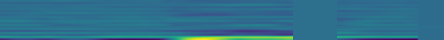

Shape: 40x444


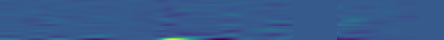

Shape: 40x444


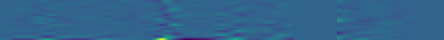

Shape: 40x444
------------------------------------------------------------
File: ../data/google_speech/train/audio/silence/pink_noise-316000.wav
Total Length: 1.0 seconds
Label: silence
0.0s-1.0s of original clip


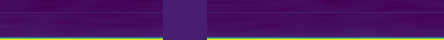

Shape: 40x444


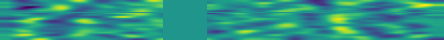

Shape: 40x444


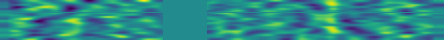

Shape: 40x444


In [70]:
sg_cfg= SpectrogramConfig(hop=72, f_max=8000, top_db=80, f_min=20)
cfg = AudioConfig(cache=True, max_to_pad=None, mfcc=True, delta=True, sg_cfg=sg_cfg)
data_pct = 1
db_audio = (al_train.use_partial_data(data_pct)
         .split_by_rand_pct(0.1, seed=seed)
         .label_from_folder()
         .transform(tfms)
         .databunch(bs=256))
db_audio.show_batch(2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


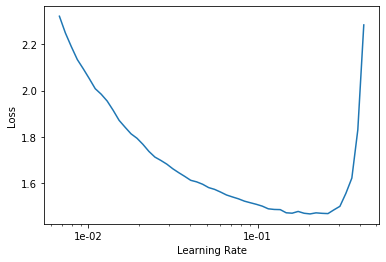

In [74]:
learn = audio_learner(db_audio, pretrained=False)
learn.lr_find(start_lr=3e-03);learn.recorder.plot()

Since we are 10xing the dataset, I'm not sure how many epochs. Let's train 5 epochs at 1e-2 and see where that gets us.

In [76]:
learn.fit_one_cycle(5, max_lr=slice(1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.602604,0.613424,0.804037,02:03
1,0.297346,0.223854,0.927361,01:51
2,0.203205,0.131409,0.962133,01:52
3,0.127746,0.097441,0.971269,01:53
4,0.078333,0.078574,0.976720,01:53


In [79]:
learn.export('/home/jupyter/google-mfcc-stg1.pkl')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


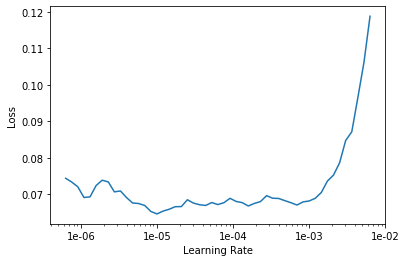

In [77]:
learn.lr_find();learn.recorder.plot()

In [92]:
learn2 = load_learner('/home/jupyter/', 'google-mfcc-stg1.pkl')

In [93]:
learn2.data = db_audio

In [97]:
learn2.fit_one_cycle(5, max_lr=slice(5e-4), callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy')])

epoch,train_loss,valid_loss,accuracy,time
0,0.064000,0.105646,0.969501,01:50
1,0.089607,0.094815,0.971563,01:52
2,0.065892,0.085146,0.977752,01:53
3,0.045350,0.067774,0.982024,01:53
4,0.033628,0.066867,0.982466,01:53


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.U

Better model found at epoch 0 with accuracy value: 0.9801090359687805.


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.U

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.U

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.U

In [103]:
learn2.export('/home/jupyter/google-mfcc-stg2.pkl')

## Interpretation

At this point it looks like we have maxed out our training and accuracy. I experimented with pushing it a bit further but it just overfit, so let's look for areas we can improve.

In [99]:
interp = ClassificationInterpretation.from_learner(learn)

When we listen to examples below, the label is in the order 'prediction/actual/loss/probability', so it looks like we are doing even better than we thought, because many of our top losses are mislabeled. This would be a great place to have the ImageCleaner Widget for Audio in order to relabel and fit a bit more. 

File: ../data/google_speech/train/audio/up/d90b4138_nohash_0.wav
Total Length: 1.0 seconds
Label: unknown/up / 19.07 / 0.00
0.0s-1.0s of original clip


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


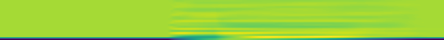

Shape: 40x444


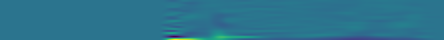

Shape: 40x444


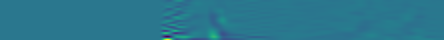

Shape: 40x444
File: ../data/google_speech/train/audio/on/36050ef3_nohash_0.wav
Total Length: 1.0 seconds
Label: unknown/on / 16.31 / 0.00
0.0s-1.0s of original clip


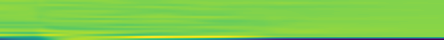

Shape: 40x444


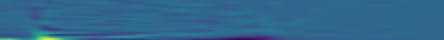

Shape: 40x444


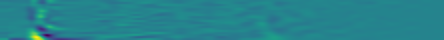

Shape: 40x444
File: ../data/google_speech/train/audio/yes/763188c4_nohash_0.wav
Total Length: 1.0 seconds
Label: unknown/yes / 9.11 / 0.00
0.0s-1.0s of original clip


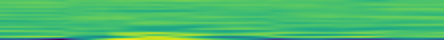

Shape: 40x444


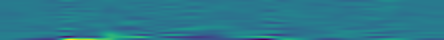

Shape: 40x444


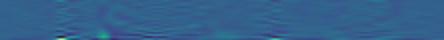

Shape: 40x444
File: ../data/google_speech/train/audio/go/190821dc_nohash_2.wav
Total Length: 1.0 seconds
Label: unknown/go / 8.38 / 0.00
0.0s-1.0s of original clip


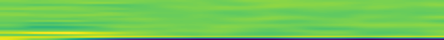

Shape: 40x444


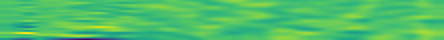

Shape: 40x444


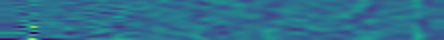

Shape: 40x444
File: ../data/google_speech/train/audio/yes/3bfd30e6_nohash_1.wav
Total Length: 1.0 seconds
Label: unknown/yes / 7.88 / 0.00
0.0s-1.0s of original clip


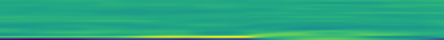

Shape: 40x444


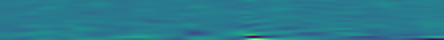

Shape: 40x444


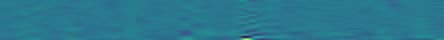

Shape: 40x444
File: ../data/google_speech/train/audio/yes/964e8cfd_nohash_2.wav
Total Length: 1.0 seconds
Label: unknown/yes / 7.67 / 0.00
0.0s-1.0s of original clip


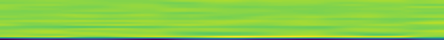

Shape: 40x444


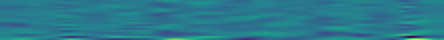

Shape: 40x444


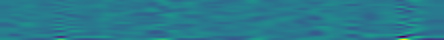

Shape: 40x444
File: ../data/google_speech/train/audio/go/3c257192_nohash_1.wav
Total Length: 1.0 seconds
Label: no/go / 7.28 / 0.00
0.0s-1.0s of original clip


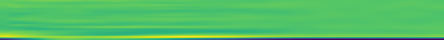

Shape: 40x444


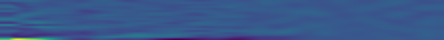

Shape: 40x444


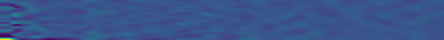

Shape: 40x444
File: ../data/google_speech/train/audio/left/1a5b9ca4_nohash_0.wav
Total Length: 1.0 seconds
Label: stop/left / 7.14 / 0.00
0.0s-1.0s of original clip


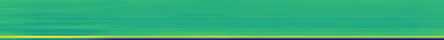

Shape: 40x444


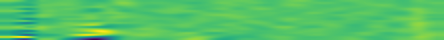

Shape: 40x444


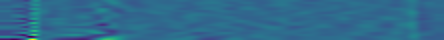

Shape: 40x444
File: ../data/google_speech/train/audio/on/a42a88ff_nohash_0.wav
Total Length: 1.0 seconds
Label: unknown/on / 6.47 / 0.00
0.0s-1.0s of original clip


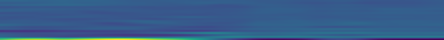

Shape: 40x444


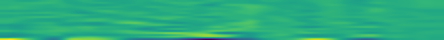

Shape: 40x444


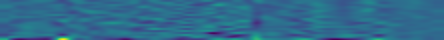

Shape: 40x444


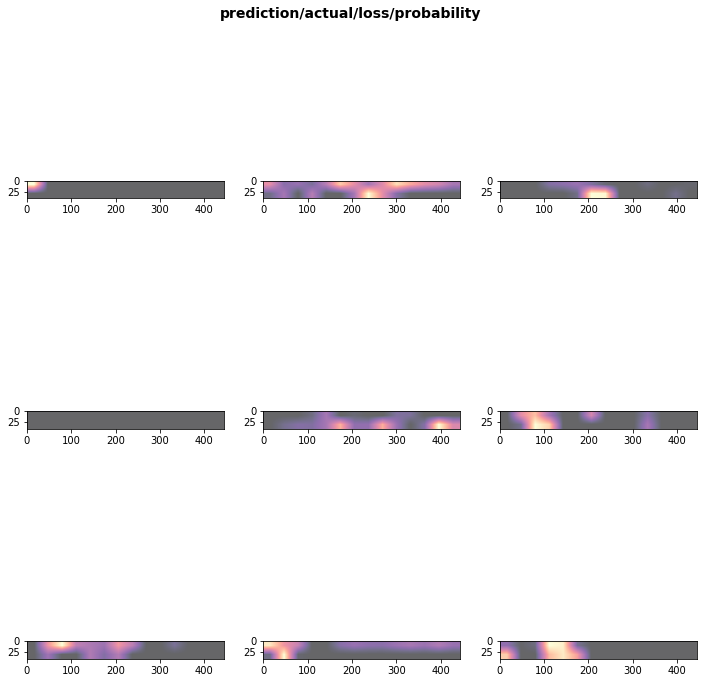

In [102]:
interp.plot_top_losses(9)

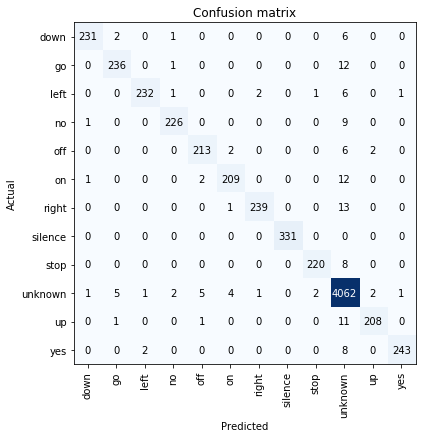

In [105]:
interp.plot_confusion_matrix(figsize=(6,6))

## Inference

### Algorithmically generating our own silence examples

So the training set has very simple "silence" but the test set has lots of examples that are completely different, including some that are pure zeros. I've cheated a little bit and selected samples that the model had trouble with after I'd gone through the training stage so that we won't have to retrain the model. Since we have no labels we can only assume these are labeled as silence and not unknown. Let's listen to a few. As you can hear they have a less constant and more warbly sound to them, which seems 

In [69]:
clips = ['clip_8bfc06738.wav', 'clip_c619eff73.wav', 'clip_f3e8ee14a.wav', 'clip_302be5b5f.wav', 'clip_91571799b.wav', 'clip_30982764a.wav']
for clip in clips: AudioItem(path=str(PATH_TEST/clip)).show()

File: ../data/google_speech/test/audio/clip_8bfc06738.wav
Total Length: 1.0 seconds


File: ../data/google_speech/test/audio/clip_c619eff73.wav
Total Length: 1.0 seconds


File: ../data/google_speech/test/audio/clip_f3e8ee14a.wav
Total Length: 1.0 seconds


File: ../data/google_speech/test/audio/clip_302be5b5f.wav
Total Length: 1.0 seconds


File: ../data/google_speech/test/audio/clip_91571799b.wav
Total Length: 1.0 seconds


File: ../data/google_speech/test/audio/clip_30982764a.wav
Total Length: 1.0 seconds
